In [ ]:
!pip install patool
import patoolib
patoolib.extract_archive('/content/drive/My Drive/Pix2Pix/NaturalScene.zip')

     |████████████████████████████████| 81kB 3.3MB/s 
patool: Extracting /content/drive/My Drive/Pix2Pix/NaturalScene.zip ...
patool: running /usr/bin/7z x -o./Unpack_fk3rtmgb -- "/content/drive/My Drive/Pix2Pix/NaturalScene.zip"
patool: ... /content/drive/My Drive/Pix2Pix/NaturalScene.zip extracted to `NaturalScene' (multiple files in root).


'NaturalScene'

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Concatenate, LeakyReLU, BatchNormalization
from tensorflow.keras.layers import Input, Dropout, Activation, Reshape, Dense, Flatten
from tensorflow.keras.layers import Conv2DTranspose as Deconv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras import backend as K

import matplotlib.pyplot as plt
import cv2
import time
import numpy as np
import os

from skimage.color import rgb2gray
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
print("Moduels loaded...")

Moduels loaded...


In [ ]:
#Define Discriminator
def define_dis(gray_img_shape, color_img_shape):
  init = RandomNormal(stddev=0.02)
  src_img = Input(shape=(gray_img_shape))
  target_img = Input(shape=(color_img_shape))

  merge = Concatenate()([src_img, target_img])
  d = Conv2D(64, kernel_size=(4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(merge)
  d = LeakyReLU(0.2)(d)

  d = Conv2D(128, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(d)
  d = BatchNormalization()(d)
  d = LeakyReLU(0.2)(d)

  d = Conv2D(256, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(d)
  d = BatchNormalization()(d)
  d = LeakyReLU(0.2)(d)

  d = Conv2D(256, (4, 4), padding='same', kernel_initializer=init)(d)
  d = BatchNormalization()(d)
  d = LeakyReLU(0.2)(d)

  d = Flatten()(d)
  d = Dense(100)(d)
  d = BatchNormalization()(d)
  d = LeakyReLU(0.2)(d)

  output = Dense(1, activation='sigmoid')(d)

  model = Model([src_img, target_img], output)

  return model

In [ ]:
#Define Encoder helper function
def encoder(layer_in, n_filters, batchnorm=True):
  init = RandomNormal(stddev=0.02)

  enc = Conv2D(n_filters, (4, 4), strides=(2,2),padding='same', kernel_initializer=init)(layer_in)

  if batchnorm:
    enc = BatchNormalization()(enc, training=True)
  enc = LeakyReLU(0.2)(enc)
  return enc

#Define Decoder helper function
def decoder(layer_in, skip_in, n_filters, dropout=True):
  init = RandomNormal(stddev=0.02)

  dec = Deconv2D(n_filters, kernel_size=(4, 4), padding='same', strides=(2, 2) ,kernel_initializer=init)(layer_in)
  dec = BatchNormalization()(dec, training=True)

  if dropout:
    dec = Dropout(0.5)(dec, training=True)
  dec = Concatenate()([dec, skip_in])
  dec = Activation('relu')(dec)

  return dec

In [ ]:
#Define Generator
def define_gen(image_shape):
  init = RandomNormal(stddev=0.02)

  input_layer = Input(shape=image_shape)

  enc1 = encoder(input_layer, 64, batchnorm=False)
  enc2 = encoder(enc1, 128)
  enc3 = encoder(enc2, 256)
  enc4 = encoder(enc3, 512)
  enc5 = encoder(enc4, 512)
  enc6 = encoder(enc5, 512)

  b = Conv2D(512, kernel_size=(4, 4), strides=(2, 2), kernel_initializer=init, padding='same')(enc6)
  b = Activation('relu')(b)

  dec1 = decoder(b, enc6, 512)
  dec2 = decoder(dec1, enc5, 512)
  dec3 = decoder(dec2, enc4, 512)
  dec4 = decoder(dec3, enc3, 512, dropout=False)
  dec5 = decoder(dec4, enc2, 256, dropout=False)
  dec6 = decoder(dec5, enc1, 128, dropout=False)

  out_layer = Deconv2D(3, kernel_size=(4, 4), strides=(2, 2), activation='tanh', padding='same', kernel_initializer=init)(dec6)

  model = Model(input_layer, out_layer)
  return model

In [ ]:
#Decoding image
def decode_img(img):
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.cast(img, tf.float32)
  img = (img/127.5) - 1
  img = tf.image.resize(img, [128, 128])

  #Randomly flipping color_images for better result
  if tf.random.uniform(()) > 0.5:
    img = tf.image.flip_left_right(img)
    
  return img

#processing image
def process_path(file_path):
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img

#load_real_data
def load_real_data(root_dir):
  
  list_ds = tf.data.Dataset.list_files(root_dir)
  img_ds = list_ds.map(process_path)
  print("Files loaded...")
  return img_ds

#preparing dataset
def prepare_ds(ds, batch_size, shuffle_buffer_size=1400, flip=True):
  dataset = ds.shuffle(buffer_size=shuffle_buffer_size)
  
  image = dataset.batch(batch_size)
  color_img = next(iter(image))

  gray_img = tf.image.rgb_to_grayscale(color_img)

  return gray_img, color_img

In [ ]:
def summarize_performance(g_model, dataset, epoch, n_samples=5):
  gray_img, color_img = prepare_ds(dataset, 5)
  gen_img = g_model.predict(gray_img)
  
  #Clipping image between range (0, 1)
  color_img = (color_img + 1) /2.0
  gen_img  = (gen_img + 1) /2.0

  fig, axs = plt.subplots(nrows=5, ncols=3, figsize=(21, 21))
  axs[0, 0].set_title("Input img", fontsize=20)
  axs[0, 1].set_title("Ground truth", fontsize=20)
  axs[0, 2].set_title("Prediction", fontsize=20)
  
  for i in range(n_samples):
    #Plotting input gray image
    axs[i, 0].imshow(gray_img[i, :, :, 0], cmap='gray')

    #plotting True colored image
    axs[i, 1].imshow(color_img[i])

    #Plotting Predicted image
    axs[i, 2].imshow(gen_img[i])
  
  if not os.path.exists('Image'):
    os.makedirs('Image')
  plt.savefig("Image/Plot_%d_epoch"%( epoch) )
  plt.close()
  print("\nSaving Done...")

In [ ]:
#LOading data
train_root_Dir = '/content/NaturalScene/seg_train/seg_train/*/*.jpg'
test_root_Dir = '/content/NaturalScene/seg_test/seg_test/*/*.jpg'
img_ds = load_real_data(train_root_Dir)
test_ds = load_real_data(test_root_Dir)

gray_img, color_img = prepare_ds(img_ds, 10)
print("Temporary Batch shape")
print("COLOR IMAGE SHAPE = ", color_img.shape)
print("GRAY IMAGE SHAPE = ", gray_img.shape)

Files loaded...
Files loaded...
Temporary Batch shape
COLOR IMAGE SHAPE =  (10, 128, 128, 3)
GRAY IMAGE SHAPE =  (10, 128, 128, 1)


In [ ]:
gray_img_shape = (128, 128, 1)
color_img_shape = (128, 128, 3)

#Creating Generator and Discriminator
#generator = define_gen(gray_img_shape)
#discriminator = define_dis(gray_img_shape, color_img_shape)

gen_opt = Adam(lr=2e-4, beta_1=0.5)
dis_opt = Adam(lr=2e-4, beta_1=0.5)


print("Model loaded")

Model loaded


In [ ]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
LAMBDA = 100

#List for storing losses
Dloss, Gloss = list(), list()

def GenLoss(dis_gen_oup, gen_oup, target):
  gan_loss = loss_object(tf.ones_like(dis_gen_oup), dis_gen_oup)

  #Mean absolute error
  target = tf.cast(target, dtype=gen_oup.dtype)
  l1_loss = tf.reduce_mean(tf.abs(target - gen_oup))
  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss

def DisLoss(dis_real_oup, dis_gen_oup):
  real_loss = loss_object(tf.ones_like(dis_real_oup), dis_real_oup)
  fake_loss = loss_object(tf.zeros_like(dis_gen_oup), dis_gen_oup)

  total_disc_loss = real_loss + fake_loss
  return total_disc_loss

In [ ]:
#training function
@tf.function
def train_step(input_img, target_img):
  with tf.GradientTape() as genTape, tf.GradientTape() as disTape:
    #Obtain gen output
    gen_oup = generator(input_img, training=True)

    #Getting Labels from discriminator
    dis_real_oup = discriminator([input_img, target_img], training=True)
    dis_fake_oup = discriminator([input_img, gen_oup], training=True)

    #Getting losses for outputs from respective model
    gen_loss = GenLoss(dis_fake_oup, gen_oup, target_img)
    dis_loss = DisLoss(dis_real_oup, dis_fake_oup)

    #Obtaining the gradients
    gen_gradients = genTape.gradient(gen_loss, generator.trainable_variables)
    dis_gradients = disTape.gradient(dis_loss, discriminator.trainable_variables)

    #Applying gradients
    gen_opt.apply_gradients(zip(gen_gradients, generator.trainable_variables))
    dis_opt.apply_gradients(zip(dis_gradients, discriminator.trainable_variables))
  
  return dis_loss, gen_loss

In [ ]:
def printPat(n, len):
  string = ""
  for i in range(n):
    string += "="
  string += ">"
  for i in range(n, len):
    string += "."
  return string

In [ ]:
def fit(n_epochs, dataset, test_set, batch_size=128, StatFreq = 20, n_steps=79):
  total_img = int(tf.data.experimental.cardinality(dataset).numpy())
  total_batch = int(total_img / batch_size)
  divFact = int(total_batch / n_steps)
  print("Total number of batches = %d"%(total_batch))
  for epoch in range(n_epochs):
    printVal = 0
    start = time.time()

    batch_st = time.time()
    for i in range(total_batch):
      #Getting target, source images
      gray_img, color_img = prepare_ds(dataset, batch_size)

      #Training models and obtaining losses
      disLoss, genLoss = train_step(gray_img, color_img)

      Dloss.append(disLoss)
      Gloss.append(genLoss)
      
      if i > divFact*printVal: 
        printVal += 1
        print(end='\r')
        print("[%s]%d/%d || DisLoss = %.4f || GenLoss = %.4f || timePerStep = %ds"%(printPat(printVal, 70), i+1, total_batch ,disLoss, genLoss, time.time() - batch_st), end='')
        batch_st = time.time()

    print("\n%3d||DisLoss = %.4f || GenLoss = %.4f || time = %ds"%(epoch+1, disLoss, genLoss, time.time()-start))

    #Summarizing performance after every 20 epochs
    if (epoch+1) %  StatFreq == 0:

      summarize_performance(generator, test_set, epoch+1)
    
    if (epoch+1) % 5 == 0:
      generator.save('/content/drive/My Drive/Pix2Pix/gen_model')
      discriminator.save('/content/drive/My Drive/Pix2Pix/dis_model')      
      print(end='\n')

In [ ]:
EPOCHS = 10
fit(EPOCHS, img_ds, test_ds, 16, 1)

Total number of batches = 877
[=========================================================================>]866/877 || DisLoss = 1.0541 || GenLoss = 4.5969 || timePerStep = 15s
  1||DisLoss = 1.0541 || GenLoss = 4.4102 || time = 1185s

Saving Done...
[=========================================================================>]866/877 || DisLoss = 1.0307 || GenLoss = 3.8352 || timePerStep = 15s
  2||DisLoss = 1.1016 || GenLoss = 3.8092 || time = 1117s

Saving Done...
[=========================================================================>]866/877 || DisLoss = 1.1038 || GenLoss = 3.6767 || timePerStep = 15s
  3||DisLoss = 1.0304 || GenLoss = 3.8252 || time = 1116s

Saving Done...
[=========================================================================>]866/877 || DisLoss = 1.0540 || GenLoss = 4.2212 || timePerStep = 15s
  4||DisLoss = 1.0537 || GenLoss = 3.7950 || time = 1127s

Saving Done...
[=========================================================================>]866/877 || DisLoss

In [ ]:
"""generator.save('/content/drive/My Drive/Pix2Pix/gen_model')
discriminator.save('/content/drive/My Drive/Pix2Pix/dis_model')"""

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/My Drive/Pix2Pix/gen_model/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/Pix2Pix/dis_model/assets


In [ ]:
generator = tf.keras.models.load_model('/content/drive/My Drive/Pix2Pix/gen_model')
discriminator = tf.keras.models.load_model('/content/drive/My Drive/Pix2Pix/dis_model')

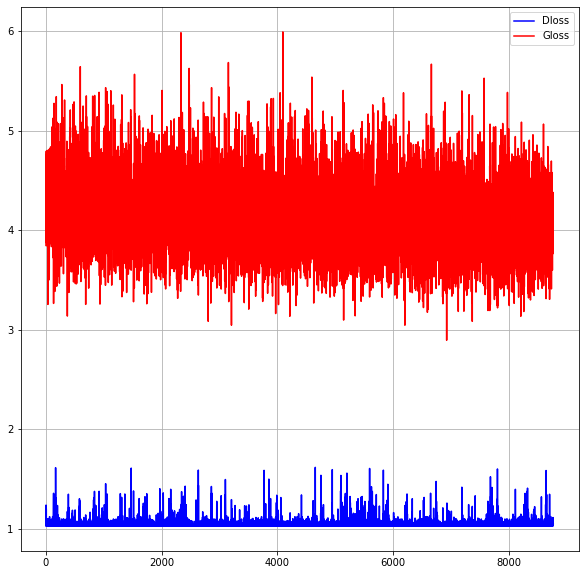

In [ ]:
plt.figure(figsize=(10, 10))
plt.grid(True)
plt.plot(Dloss, color='blue')
plt.plot(Gloss, color='red')
plt.legend(['Dloss', 'Gloss'])
plt.show()

Predicted:- 98.68% Confident
Ground Truth:- 1.96% Confident


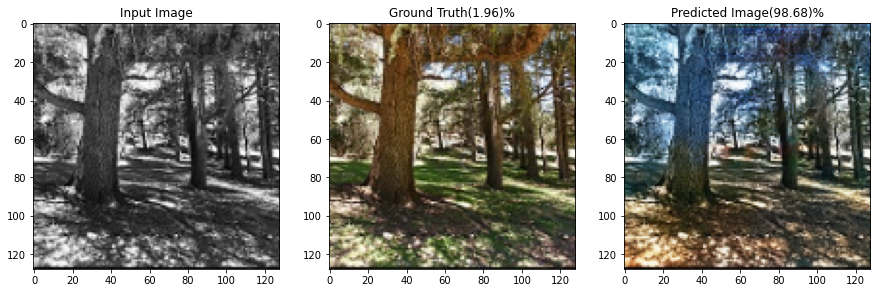

In [ ]:
gray_img, color_img = prepare_ds(test_ds, 1)

gen_img = generator.predict(gray_img)
dis_oup_pred = discriminator.predict([gray_img, gen_img])
dis_oup_true = discriminator.predict([gray_img, color_img])

color_img = (color_img + 1)/2.0
gen_img = (gen_img + 1)/2.0
percent = "%"
print("Predicted:- %.2f%s Confident"%(dis_oup_pred[0]*100.0, percent))
print("Ground Truth:- %.2f%s Confident"%(dis_oup_true[0]*100.0, percent))
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 15))
axs[0].imshow(gray_img[0, :, :, 0], cmap='gray')
axs[0].set_title("Input Image")

axs[1].imshow(color_img[0].numpy())
axs[1].set_title("Ground Truth(%.2f)%s"%(dis_oup_true[0]*100.0, percent))

axs[2].imshow(gen_img[0])
axs[2].set_title("Predicted Image(%.2f)%s"%(dis_oup_pred[0]*100.0, percent))

plt.show()

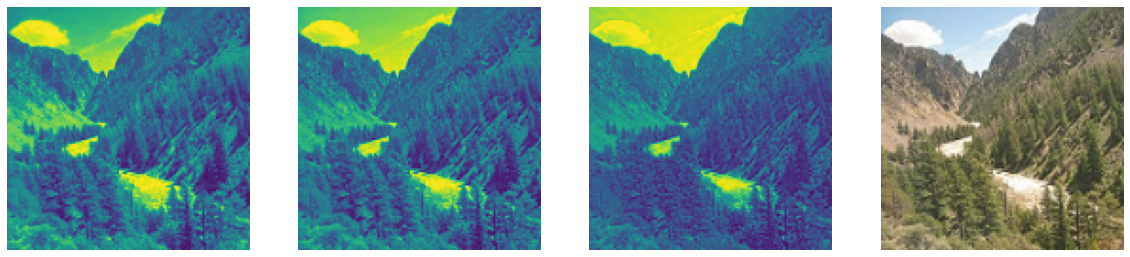

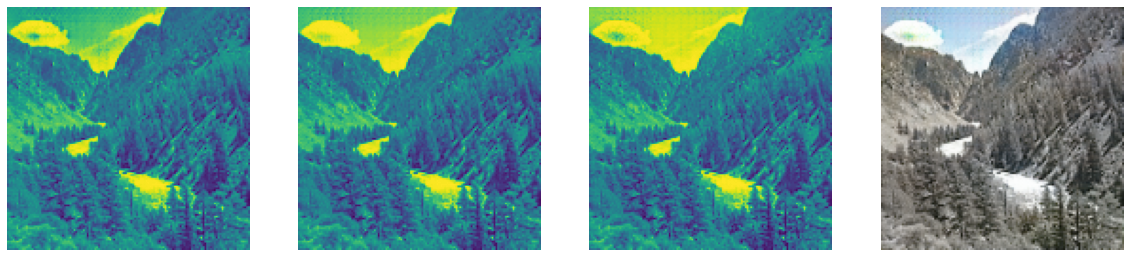

In [ ]:
plt.figure(figsize=(20, 20))
for i in range(3):
  plt.subplot(1, 4, i+1)
  plt.imshow(color_img[0, :, :, i])
  plt.axis("off")

plt.subplot(1, 4, 4)
plt.imshow(color_img[0])
plt.axis("off")
plt.show()

plt.figure(figsize=(20, 20))
for i in range(3):
  plt.subplot(2, 4, i+1)
  plt.imshow(gen_img[0, :, :, i])
  plt.axis("off")

plt.subplot(2, 4, 4)
plt.imshow(gen_img[0])
plt.axis("off")
plt.show()

Predicted:- 16.45% Confident
Ground Truth:- 9.32% Confident


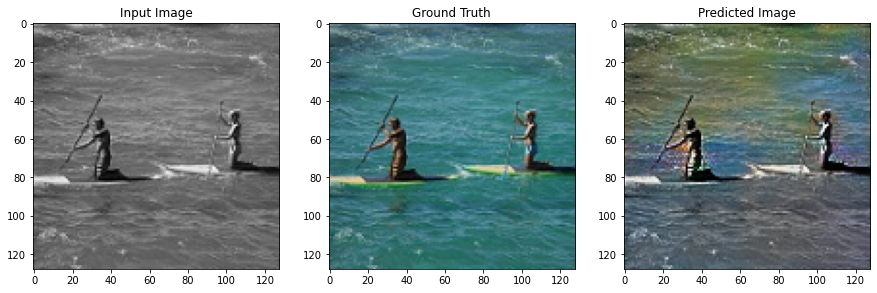

In [ ]:
gray_img, color_img = prepare_ds(img_ds, 1)

gen_img = generator.predict(gray_img)
dis_oup_pred = discriminator.predict([gray_img, gen_img])
dis_oup_true = discriminator.predict([gray_img, color_img])

color_img = (color_img + 1)/2.0
gen_img = (gen_img + 1)/2.0
percent = "%"
print("Predicted:- %.2f%s Confident"%(dis_oup_pred[0]*100.0, percent))
print("Ground Truth:- %.2f%s Confident"%(dis_oup_true[0]*100.0, percent))
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 15))
axs[0].imshow(gray_img[0, :, :, 0], cmap='gray')
axs[0].set_title("Input Image")

axs[1].imshow(color_img[0].numpy())
axs[1].set_title("Ground Truth")

axs[2].imshow(gen_img[0])
axs[2].set_title("Predicted Image")

plt.show()